In [10]:
from scipy.spatial import KDTree
from sklearn.metrics import silhouette_score

import time
import math
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import heapq

class Cluster:
    def __init__(self, points, c=4, alpha=0.4):        
        self.points = points
        self.mean = np.mean(self.points, axis=0)

        self.c = c
        self.alpha = alpha

        self.set_reps()
        self.closest = None
        self.closest_dist = -1

    def set_reps(self):
        if len(self.points) >= self.c:
            self.reps = random.sample(self.points, self.c)
        else:
            self.reps = random.sample(self.points, len(self.points))

        self.mean = np.mean(self.reps, axis=0)
        self.reps = [rep_point + (self.mean - rep_point) * self.alpha for rep_point in self.reps]

    def set_nearest(self, nearest_dist, nearest_idx):
        self.nearest_dist = nearest_dist
        self.nearest_idx = nearest_idx

    def __str__(self):
        return f'{super().__str__()}, points: {self.points}, mean: {self.mean}, reps: {self.reps}'

# heap
def insert(heap, value):
    heap.append(value)
    index = len(heap) - 1
    
    # heap up
    parent_index = math.floor((index - 1) / 2)
    while index > 0 and heap[index][0] < heap[parent_index][0]:
        heap[index], heap[parent_index] = heap[parent_index], heap[index]
        index = parent_index
        parent_index = math.floor((index - 1) / 2)

def extract_min(heap):
    heap[0], heap[len(heap) - 1] = heap[len(heap) - 1], heap[0]
    min_value = heap.pop()
    heapify_down(heap, 0)
    return min_value

def heapify_down(heap, index):
    while index < len(heap):
        min_index = index
        left_child_index = 2 * index + 1
        right_child_index = 2 * index + 2
        if left_child_index < len(heap) and heap[left_child_index][0] < heap[min_index][0]:
            min_index = left_child_index
        if right_child_index < len(heap) and heap[right_child_index][0] < heap[min_index][0]:
            min_index = right_child_index
        if min_index == index:
            break
        heap[index], heap[min_index] = heap[min_index], heap[index]
        index = min_index

In [11]:
def update_q(clusters, T, data):
    Q = []
    for i in range(len(clusters)):
        min_dist = float('inf')
        k = 1
        while(min_dist == float('inf')):
            k += 1
            for rep in clusters[i].reps:
                dist, idx = T.query(rep, k=k)
                if dist[-1] < min_dist and data['info'][idx[-1]] != clusters[i]:
                    min_dist = dist[-1]
                    clusters[i].closest = data['info'][idx[-1]]

        insert(Q, (min_dist, clusters[i]))

    return Q

def cure(S, k, c=4, alpha=0.4):
    clusters = [Cluster([point], c=c, alpha=alpha) for point in S]

    data = np.zeros(len(S), dtype=[('point', float, S.shape[1]), ('info', object)])
    data['point'] = S
    data['info'] = clusters
    T = KDTree(S)
    Q = update_q(clusters, T, data)

    while len(Q) > k:
        u = extract_min(Q)[1]
        v = u.closest
        w = Cluster(u.points + v.points, c=c, alpha=alpha)
        Q = [elem for elem in Q if elem[1] != v]
        clusters = [cluster for cluster in clusters if cluster != u and cluster != v]
        clusters.append(w)

        rows_to_remove = np.isin(S, u.reps + v.reps).all(axis=1)
        S = S[~rows_to_remove]
        S = np.vstack((S, w.reps))

        data = data[~rows_to_remove]
        for rep in w.reps:
            data = np.append(data, np.array([(rep, w)], dtype=data.dtype))
        T = KDTree(S)
        Q = update_q(clusters, T, data)

    return clusters

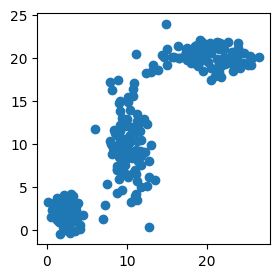

silhouette score: 0.7072348645456501


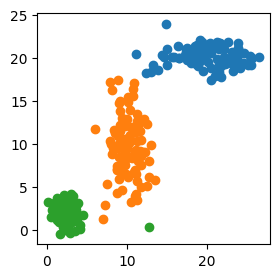

In [12]:
np.random.seed(1)

mean1 = [2, 2]
mean2 = [10, 10]
mean3 = [20, 20]

cov1 = [[1, 0], [0, 1]]
cov2 = [[2, 0], [0, 12]]
cov3 = [[10, 0], [0, 1]]

cluster1_data = np.random.multivariate_normal(mean1, cov1, size=100)
cluster2_data = np.random.multivariate_normal(mean2, cov2, size=100)
cluster3_data = np.random.multivariate_normal(mean3, cov3, size=100)

X = np.concatenate((cluster1_data, cluster2_data, cluster3_data))

plt.figure(figsize=(3,3))
plt.scatter(X[:,0],X[:,1])
plt.show()

clusters = cure(X, 3)

plt.figure(figsize=(3,3))
for cluster in clusters:
    cluster_points_stack = np.vstack(cluster.points)
    plt.scatter(cluster_points_stack[:,0], cluster_points_stack[:,1])

points = []
labels = []
i = 0
for cluster in clusters:
    for _ in range(len(cluster.points)):
        labels.append(i)
    points.append(np.vstack(cluster.points))
    i += 1
points = np.vstack(points)
print('silhouette score:', silhouette_score(points, labels))

# Wczytanie danych Starbucks
Dane zostały wczytane z pliku "directory.csv". Z danych zostały wybrane dwie ostatnie kolumny zawierające informację o współrzędnych punktów starbucks.

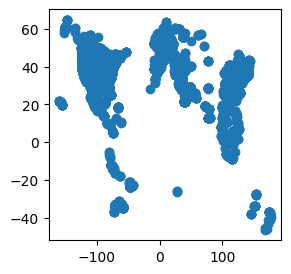

In [13]:
data = pd.read_csv('directory.csv')
X_starbucks = data.iloc[:, -2:].values

plt.figure(figsize=(3,3))
plt.scatter(X_starbucks[:,0],X_starbucks[:,1])
plt.show()

np.random.shuffle(X_starbucks)

# Testy
- Test liczby klastrów
- Test wielkości zbioru
- Test parametru c(liczba reprezentantów)
- Test parametru alpha

In [14]:
# Funkcje pomocnicze do testów

def measure_time(X, cluster_num, c=4, alpha=0.4):
    start_time = time.time()
    clusters = cure(X, cluster_num, c=c, alpha=alpha)
    end_time = time.time()
    return clusters, end_time - start_time

def plot_clusters(clusters, title, i):
    plt.subplot(1, 3, i)
    for cluster in clusters:
        cluster_points_stack = np.vstack(cluster.points)
        plt.scatter(cluster_points_stack[:,0], cluster_points_stack[:,1])
    plt.title(title)

def compute_silhouette(clusters):
    points = []
    labels = []
    i = 0
    for cluster in clusters:
        for _ in range(len(cluster.points)):
            labels.append(i)
        points.append(np.vstack(cluster.points))
        i += 1
    points = np.vstack(points)
    return silhouette_score(points, labels)

## Test liczby klastrów

,Liczba klastrów,Czas działania [s],Miara silhouette
0,3,19.192270,0.684903
1,6,18.788851,0.639432
2,10,19.220457,0.554329


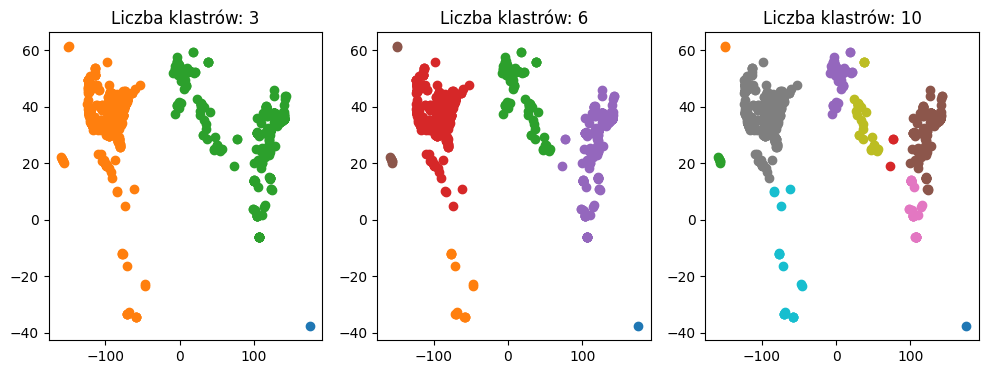

In [15]:
cluster_num_list = [3, 6, 10]
time_list = []
silhouette_list = []

plt.figure(figsize=(12,4))
for i in range(len(cluster_num_list)):
    clusters, elapsed_time = measure_time(X_starbucks[:1000,:], cluster_num_list[i])
    time_list.append(elapsed_time)
    silhouette_list.append(compute_silhouette(clusters))
    plot_clusters(clusters, f'Liczba klastrów: {cluster_num_list[i]}', i+1)

pd.DataFrame({
    'Liczba klastrów': cluster_num_list,
    'Czas działania [s]': time_list,
    'Miara silhouette': silhouette_list
})

## Test wielkości zbioru

,Wielkość zbioru,Czas działania [s],Miara silhouette
0,100,0.263034,0.777437
1,1000,20.132657,0.769053
2,5000,526.687790,0.675028


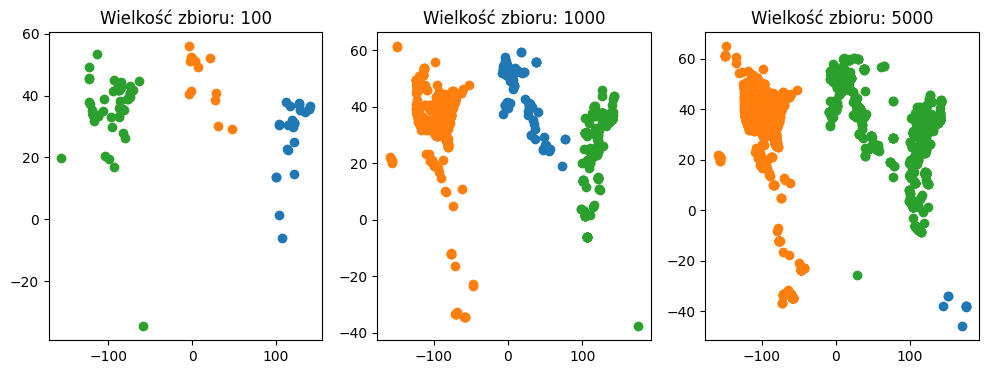

In [16]:
x_size_list = [100, 1000, 5000]
time_list = []
silhouette_list = []

plt.figure(figsize=(12,4))
for i in range(len(x_size_list)):
    clusters, elapsed_time = measure_time(X_starbucks[:x_size_list[i],:], 3)
    time_list.append(elapsed_time)
    silhouette_list.append(compute_silhouette(clusters))
    plot_clusters(clusters, f'Wielkość zbioru: {x_size_list[i]}', i+1)

pd.DataFrame({
    'Wielkość zbioru': x_size_list,
    'Czas działania [s]': time_list,
    'Miara silhouette': silhouette_list
})

## Test hiperparametrów alggorytmu CURE

### c

,Hiperparametr c,Czas działania [s],Miara silhouette
0,4,20.293543,0.769053
1,5,24.763016,0.684903
2,6,29.672089,0.733626


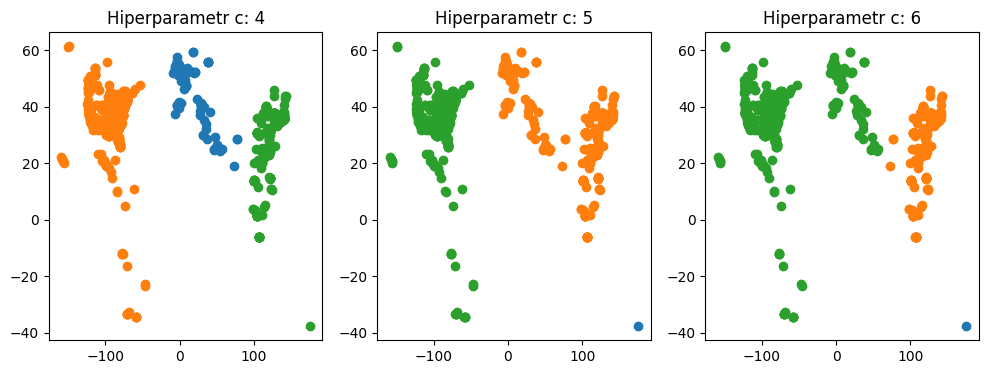

In [17]:
c_list = [4, 5, 6]
time_list = []
silhouette_list = []

plt.figure(figsize=(12,4))
for i in range(len(c_list)):
    clusters, elapsed_time = measure_time(X_starbucks[:1000,:], 3, c=c_list[i])
    time_list.append(elapsed_time)
    silhouette_list.append(compute_silhouette(clusters))
    plot_clusters(clusters, f'Hiperparametr c: {c_list[i]}', i+1)

pd.DataFrame({
    'Hiperparametr c': c_list,
    'Czas działania [s]': time_list,
    'Miara silhouette': silhouette_list
})

### alpha

,Hiperparametr alpha,Czas działania [s],Miara silhouette
0,0.4,21.509777,0.684903
1,0.5,20.096045,0.769053
2,0.6,21.744629,0.475786


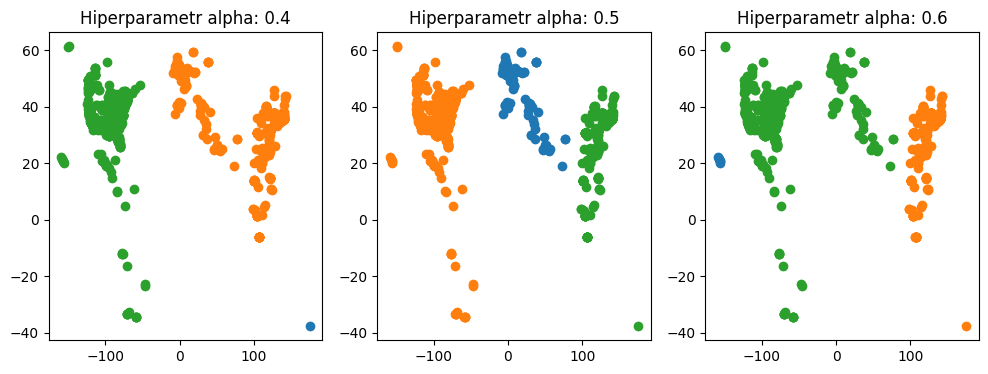

In [18]:
alpha_list = [0.4, 0.5, 0.6]
time_list = []
silhouette_list = []

plt.figure(figsize=(12,4))
for i in range(len(alpha_list)):
    clusters, elapsed_time = measure_time(X_starbucks[:1000,:], 3, alpha=alpha_list[i])
    time_list.append(elapsed_time)
    silhouette_list.append(compute_silhouette(clusters))
    plot_clusters(clusters, f'Hiperparametr alpha: {alpha_list[i]}', i+1)

pd.DataFrame({
    'Hiperparametr alpha': alpha_list,
    'Czas działania [s]': time_list,
    'Miara silhouette': silhouette_list
})